## 📘 Project Summary: Converting Stability Number Code to Domination Number

This notebook was originally designed to predict the **stability number** (i.e., independence number)  
of graphs using a Convolutional Neural Network (CNN). The original code used an ILP-based method  
(`max_independent_set_ilp`) to compute the ground truth and compared that against the CNN's predictions.

---

### ✅ What I changed to convert it to **Domination Number**:

#### 1. **Ground Truth Source Changed**  
- I replaced the ILP-based `max_independent_set_ilp(G)` with  
  `gc.domination_number(G)` from the `graphcalc` package.  
- This function gives the **exact domination number**, which I used as the label (`y`) during training and evaluation.

#### 2. **Terminology and Output Labels Updated**  
- I updated all references to “independence number” or “stability number”  
  and renamed them to **domination number** in print statements, plots, and variable names.

#### 3. **Graph Visualization Adjusted**  
- Since `graphcalc` doesn't provide the actual dominating set (only the number),  
  I added a simple `greedy_dominating_set(G)` function to approximate it.  
- I used this only for visualization (e.g., highlighting nodes in red), not for training.

#### 4. **Runtime Comparison Logic Updated**  
- I changed all ILP vs CNN timing comparisons to **GraphCalc vs CNN**,  
  since GraphCalc acts as the exact method for domination number.

---

This version keeps the same CNN model and experiment structure,  
but now it learns and predicts the **domination number** instead of the stability number.


### Comparing GraphCalc vs CNN for Domination Number

In the original stability number version, we used an ILP (Integer Linear Programming) solver  
to compute the exact maximum independent set. We then compared its result and runtime  
with the CNN model's prediction.

However, for domination number, we do not have an ILP function ready.  
Instead, we use the `graphcalc` package, which provides an exact domination number.  
So in this version, we compare:

- **GraphCalc method** (exact domination number)
- **CNN prediction** (estimated domination number)

This comparison helps us see how close the CNN comes to the true value,  
and how much faster it is compared to the exact method.


In [2]:
# Import necessary packages.

import networkx as nx
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Model
import random
import time
from itertools import combinations
import graphcalc as gc
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats


In [3]:
# Graph helper functions.
def neighborhood(G, v):
    return list(nx.neighbors(G, v))

def set_neighborhood(G, nodes):
    N = set()
    for n in nodes:
        N |= set(neighborhood(G, n))
    return list(N)

def closed_neighborhood(G, v):
    return list(set(neighborhood(G, v)).union([v]))


In [4]:
# Function to compute the domination number using graphcalc
def domination_number(G):
    return gc.domination_number(G) 

# Generate random graphs and compute their domination numbers
def generate_domination_number_data(num_graphs, max_nodes):
    graphs = []
    domination_numbers = []
    for _ in range(num_graphs):
        num_nodes = random.randint(5, max_nodes)
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        dom_num = domination_number(G)
        graphs.append(G)
        domination_numbers.append(dom_num)
    return graphs, domination_numbers

In [5]:
# Function to convert adjacency matrix and heatmap to fixed-size image
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

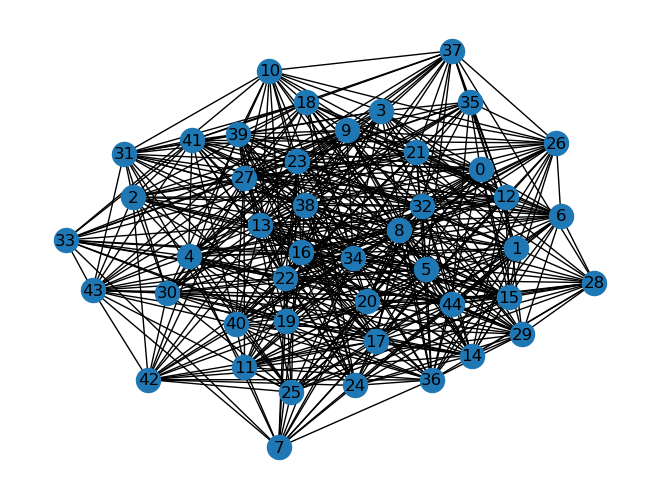

In [6]:
# Visual test with a single graph
G = nx.gnp_random_graph(45, 0.5)
nx.draw(G, with_labels=True)
plt.show()

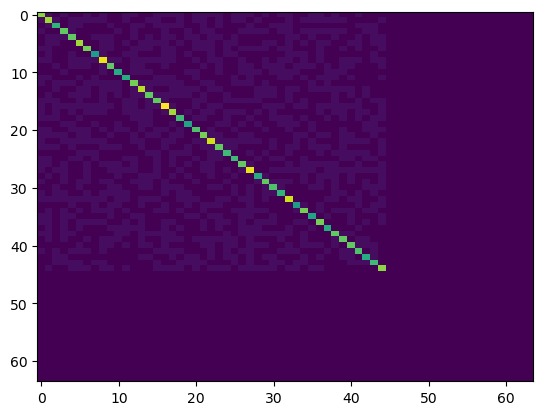

In [7]:
image = convert_to_heatmap_image(G)
plt.imshow(image, cmap='viridis', aspect='auto')
plt.show()

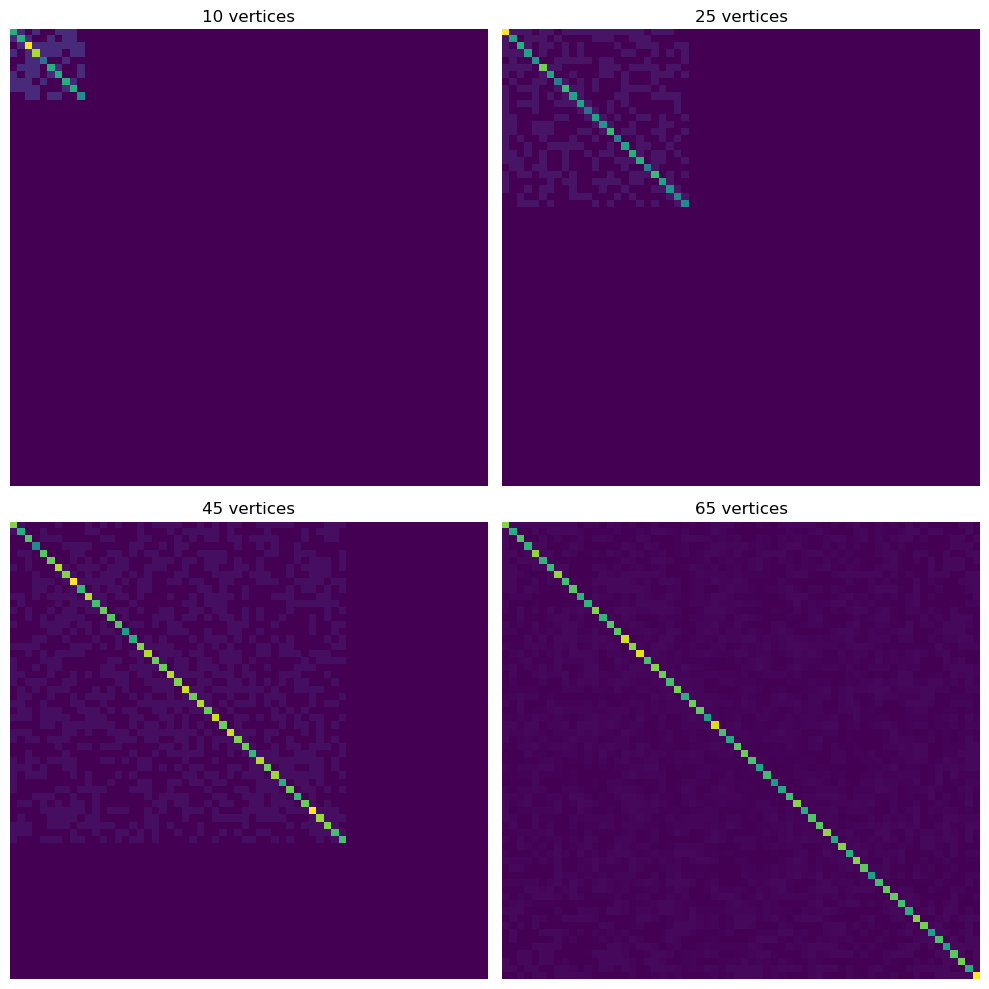

In [8]:
# Create and visualize multiple graphs of different sizes
graphs = [
    nx.gnp_random_graph(10, 0.5),
    nx.gnp_random_graph(25, 0.5),
    nx.gnp_random_graph(45, 0.5),
    nx.gnp_random_graph(65, 0.5)
]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
titles = ['10 vertices', '25 vertices', '45 vertices', '65 vertices']

for i, (G, ax) in enumerate(zip(graphs, axs.flatten())):
    image = convert_to_heatmap_image(G)
    ax.imshow(image, cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Generate dataset of random graphs with varying node sizes 10 <= n <= 64.
def generate_dataset():
    num_graphs = 100
    max_nodes = 64
    graphs, domination_numbers = generate_domination_number_data(num_graphs, max_nodes)

    # Convert graphs to images.
    target_size = 64
    images = [convert_to_heatmap_image(graph, target_size) for graph in graphs]
    X = np.array([np.array(image).reshape(target_size, target_size, 1) for image in images])
    y = np.array(domination_numbers)

    # Split dataset into training and testing.
    split_index = int(0.8 * num_graphs)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    print(f"Dataset created: {num_graphs} graphs")
    print(f"Training set: {len(X_train)} graphs")
    print(f"Test set: {len(X_test)} graphs")
    print(f"Domination number range: {min(y)} to {max(y)}")
    
    return X_train, X_test, y_train, y_test, target_size


In [10]:
X_train, X_test, y_train, y_test, target_size = generate_dataset()


Dataset created: 100 graphs
Training set: 80 graphs
Test set: 20 graphs
Domination number range: 1 to 58


/var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/ipykernel_33465/1936093043.py:24: RuntimeWarning: invalid value encountered in divide
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)
/var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/ipykernel_33465/1936093043.py:24: RuntimeWarning: invalid value encountered in cast
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)


In [11]:
# Define the CNN model.
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# Instantiate and train the model.
input_shape = (target_size, target_size, 1)
model = create_model(input_shape)
model.summary()
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 684.8071 - mae: 17.4014 - val_loss: 168.4819 - val_mae: 10.9019
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 131.3961 - mae: 7.7643 - val_loss: 72.3536 - val_mae: 3.5204
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 100.1006 - mae: 4.5193 - val_loss: 65.7106 - val_mae: 3.8726
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 69.3066 - mae: 4.0479 - val_loss: 63.6803 - val_mae: 4.5357
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 73.1380 - mae: 4.6429 - val_loss: 55.6888 - val_mae: 4.9494
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 27.9403 - mae: 3.6470 - val_loss: 40.4699 - val_mae: 5.0181
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 29.7490 - mae: 4.4135 - val_loss: 20.3197 - val_mae: 2.5550
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.5876 - mae: 2.0388 - val_loss: 23.3084 - val_mae: 3.3040
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1

In [12]:
# Evaluate the model.
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8259 - mae: 1.1203
Test MAE: 1.1202776432037354


In [13]:
# Generate a random graph with n nodes.
def test_single_graph(model, n=30):
    # Generate a random graph
    G = nx.gnp_random_graph(n, np.random.rand())

    # Convert to heatmap image
    adj_image = convert_to_heatmap_image(G)
    input_image = np.array(adj_image).reshape(1, 64, 64, 1)

    # Predict domination number
    predicted = model.predict(input_image)[0][0]
    actual = gc.domination_number(G)

    print(f"Predicted domination number for the {n}-node graph: {predicted:.2f}")
    print(f"Computed domination number for the {n}-node graph: {actual}")

    # Visualize the graph
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=500)
    plt.title(f"{n}-Node Graph")
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted domination number for the 30-node graph: 6.95
Computed domination number for the 30-node graph: 6


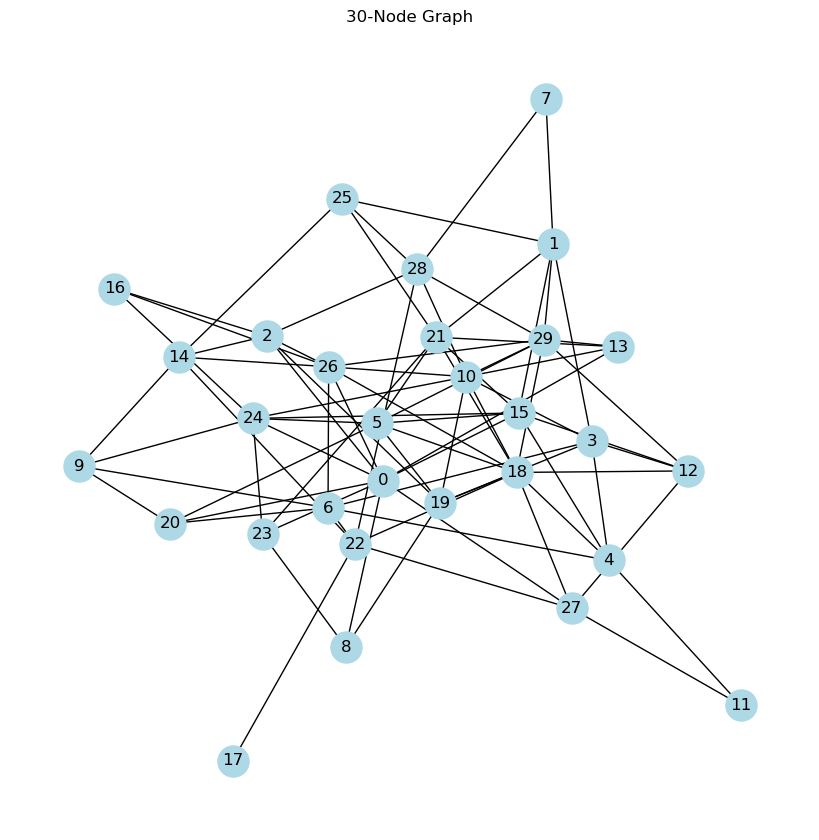

In [14]:
#to call the func. and show the plot for single grapgh one (wasnt included in the original code)
test_single_graph(model, n=30)




In [15]:
# Generate and process multiple random graphs
def test_multiple_graphs(model, num_graphs=30, num_nodes=30):
    results = []

    for i in range(num_graphs):
        G = nx.gnp_random_graph(num_nodes, np.random.rand())

        # Convert adjacency matrix to image with heatmap
        adj_image = convert_to_heatmap_image(G)
        input_image = np.array(adj_image).reshape(1, 64, 64, 1)

        # Predict and compute domination numbers
        predicted = model.predict(input_image)[0][0]
        actual = gc.domination_number(G)

        # Store the results
        results.append({
            "Graph Index": i,
            "Predicted Domination Number": predicted,
            "Actual Domination Number": actual
        })

    # Display results
    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df["Graph Index"], results_df["Predicted Domination Number"], label="Predicted", color='blue', alpha=0.6)
    plt.scatter(results_df["Graph Index"], results_df["Actual Domination Number"], label="Actual", color='red', alpha=0.6)
    plt.plot(results_df["Graph Index"], results_df["Actual Domination Number"], color='red', linestyle='dotted')
    plt.plot(results_df["Graph Index"], results_df["Predicted Domination Number"], color='blue', linestyle='dotted')
    plt.xlabel("Graph Index")
    plt.ylabel("Domination Number")
    plt.title("Predicted vs Actual Domination Numbers (Random Graphs)")
    plt.ylim(0, num_nodes + 1)
    plt.legend()
    plt.tight_layout()
    

    # Save the plot
    plt.savefig("domination_number_prediction_comparison.png")
    plt.show()
    return results_df
#to call the func. and show the plot for multiple grapgh one
test_multiple_graphs(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

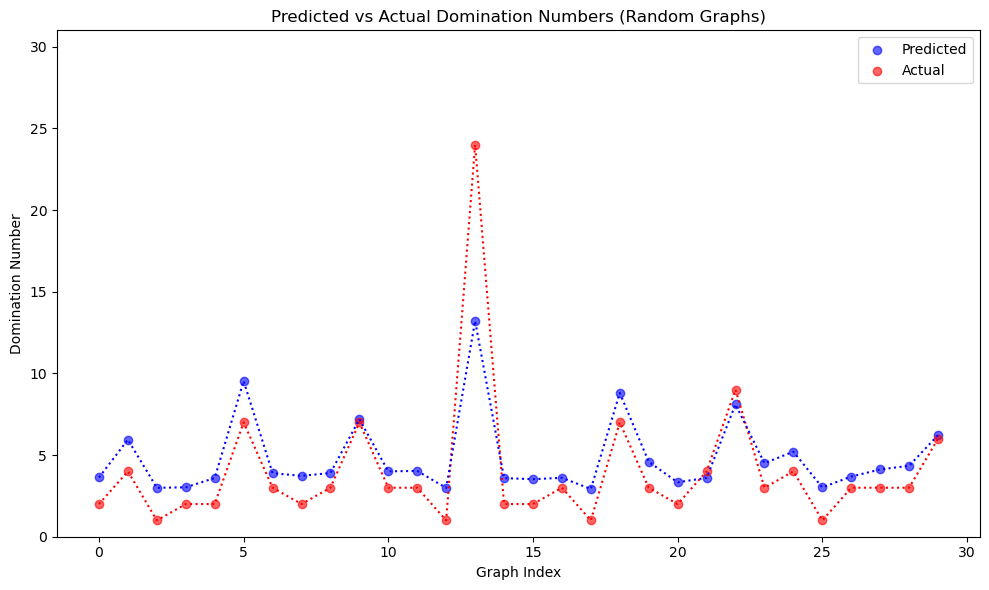

,Graph Index,Predicted Domination Number,Actual Domination Number
0,0,3.626403,2
1,1,5.942189,4
2,2,2.994370,1
3,3,3.024851,2
4,4,3.595102,2
5,5,9.534119,7
6,6,3.889749,3
7,7,3.726073,2
8,8,3.899982,3
9,9,7.193518,7


In [16]:
#to call the func. and show the plot for multiple grapgh one
test_multiple_graphs(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Test MSE: 1.8259292092243726
Test MAE: 1.1202776551246643
Test RMSE: 1.3512694806086507
Test R-squared: 0.8367884159088135
95% Confidence Interval for the Predictions: (2.5489460505092323, 5.233940454617721)


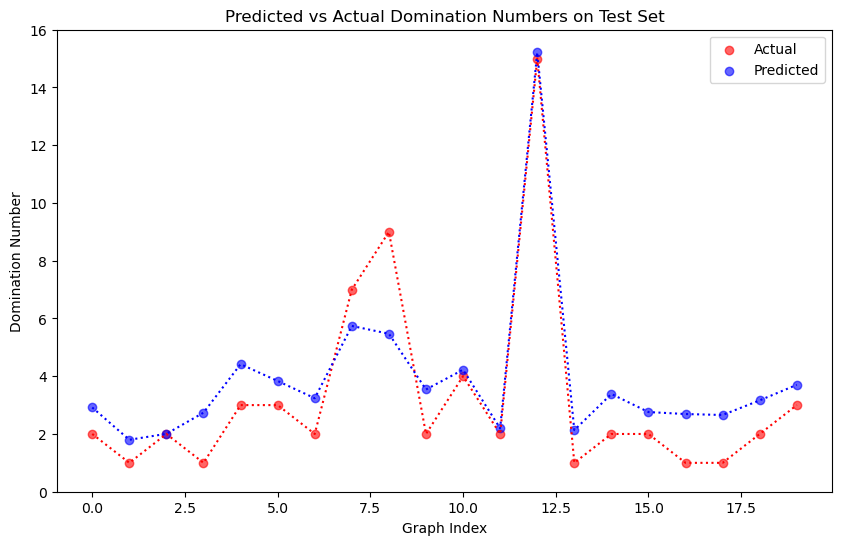

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_val = rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse_val}')
print(f'Test R-squared: {r2}')

# Calculate 95% confidence interval for predictions
conf_interval = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(y_pred), scale=stats.sem(y_pred))
print(f'95% Confidence Interval for the Predictions: {conf_interval}')

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot predicted vs actual domination numbers
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color='red', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color='blue', alpha=0.6)
plt.plot(range(len(y_test)), y_test, color='red', linestyle='dotted')
plt.plot(range(len(y_test)), y_pred, color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Domination Number")
plt.title("Predicted vs Actual Domination Numbers on Test Set")
plt.ylim(0, max(y_test) + 1)
plt.legend()


# Optionally, save the figure
plt.savefig("domination_number_prediction_comparison_test_set.png")
plt.show()

In [18]:
# Ablation Study
# Model without max pooling layers
def create_model_no_pooling(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

model_no_pooling = create_model_no_pooling(input_shape)
model_no_pooling.fit(X_train, y_train, epochs=15, validation_split=0.2)
loss_no_pooling, mae_no_pooling = model_no_pooling.evaluate(X_test, y_test)
print(f'Model without Pooling Layers - Test MAE: {mae_no_pooling}')


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 12404.0801 - mae: 59.7531 - val_loss: 1147.0575 - val_mae: 29.9461
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 591.5770 - mae: 17.7666 - val_loss: 86.4333 - val_mae: 4.9531
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 168.2096 - mae: 6.8326 - val_loss: 85.4374 - val_mae: 4.8388
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 104.1313 - mae: 5.5426 - val_loss: 84.6385 - val_mae: 4.7487
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 143.0737 - mae: 6.4364 - val_loss: 84.1031 - val_mae: 4.6895
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 130.0075 - mae: 5.7628 - val_loss: 83.7622 - val_mae: 4.6535
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 162.8302 - mae: 6.3873 - val_loss: 83.5243 - val_mae: 4.6290
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 138.6648 - mae: 6.0430 - val_loss: 83.3504 - val_mae: 4.6114
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18

In [19]:
from tensorflow.keras import Input, Model

inputs = Input(shape=(64, 64, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



In [20]:
print(model.input)   # ➜ <KerasTensor: shape=(None, 64, 64, 1) ...>
print(model.output)  # ➜ <KerasTensor: shape=(None, 1) ...>


<KerasTensor shape=(None, 64, 64, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_59>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_67>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


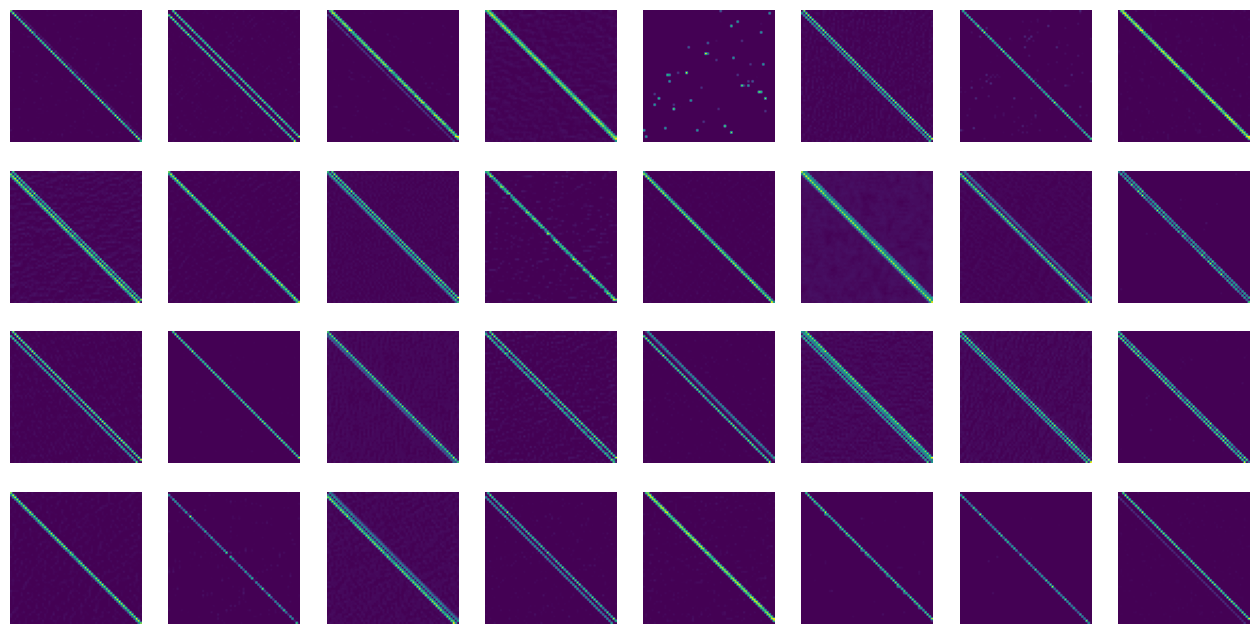

In [21]:
# Choose a random graph and convert it to an image
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Create a model to output the intermediate layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the input image
activations = activation_model.predict(input_image)

# Visualize the feature maps for a specific layer (e.g., first convolutional layer)
layer_activation = activations[0]
n_features = layer_activation.shape[-1]
size = layer_activation.shape[1]

# Plot each feature map in a grid
n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.imshow(layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

# plt.title('Feature Maps of First Convolutional Layer')
plt.show()


Dominating Set: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


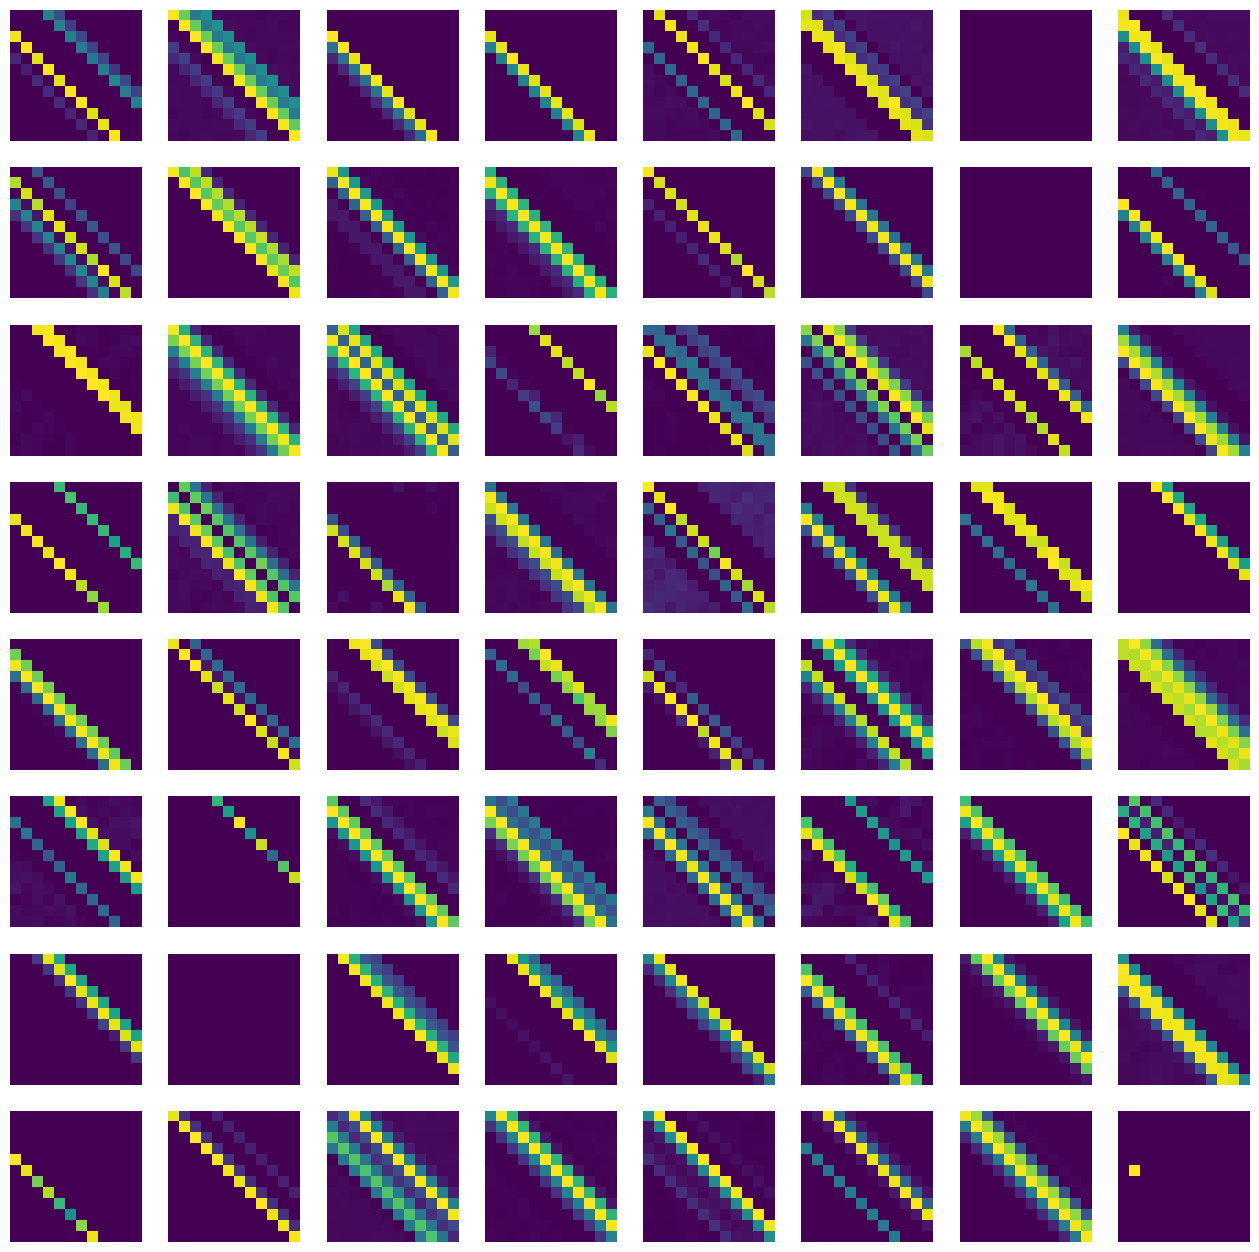

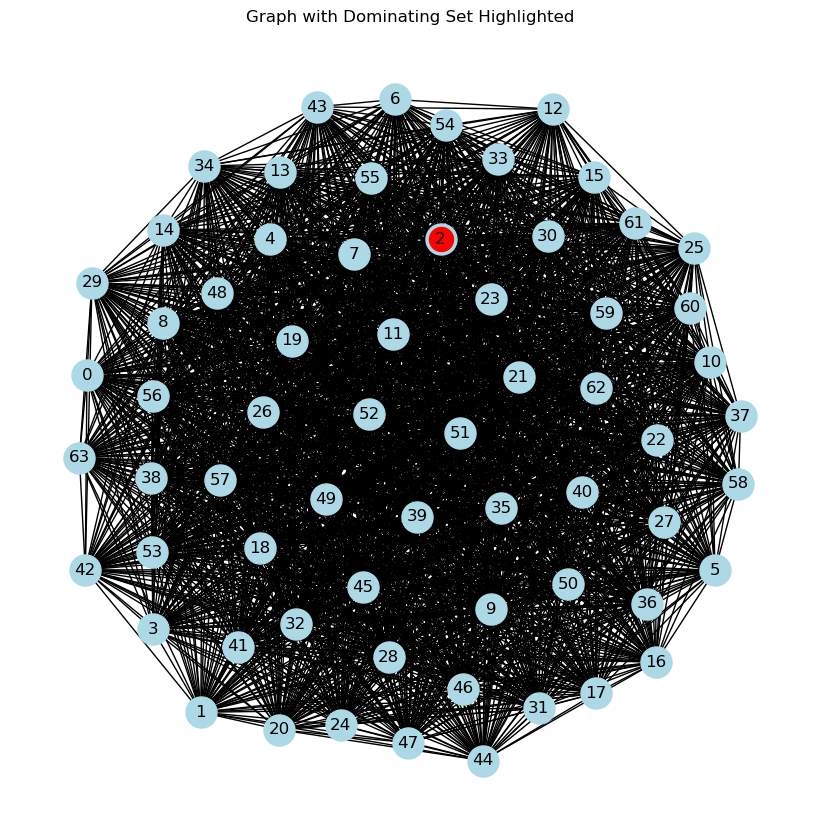

In [22]:
# Why am i  using a greedy algorithm here but not for stability number?
# -----------------------------------------------------------------------
# In the original stability number code, i used an ILP (exact solver)
# to find the maximum independent set — because i had a ready-made function
# (max_independent_set_ilp) that gave the actual node set.

# But for domination number, the library (graphcalc) gives us only the number,
# not the actual set of nodes in the dominating set.

# So to highlight something on the graph, i need to create an approximate
# dominating set ourselves — that's why i use a greedy algorithm here.

# It's only for visualization, not for model training or evaluation.

# Function to convert adjacency matrix and heatmap to fixed-size image
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

# Generate a random graph and convert it to an image
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)

# Compute the dominating set (approximate)
def greedy_dominating_set(G):
    dom_set = set()
    uncovered = set(G.nodes())

    while uncovered:
        node = max(uncovered, key=lambda n: len(set(G.neighbors(n)) & uncovered))
        dom_set.add(node)
        uncovered -= set(G.neighbors(node)) | {node}

    return list(dom_set)

dominating_set = greedy_dominating_set(G)
print(f"Dominating Set: {dominating_set}")

# Extract feature maps from the last convolutional layer
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(input_image)
last_layer_activation = activations[-1]

# Visualize the feature maps for the last convolutional layer
n_features = last_layer_activation.shape[-1]
size = last_layer_activation.shape[1]

n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.imshow(last_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

plt.show()

# Visualize the graph and highlight the dominating set
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=dominating_set, node_color='red')
plt.title('Graph with Dominating Set Highlighted')
plt.show()


In [23]:
import time

# Generate a random graph
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())

# Measure time for graphcalc (exact) method
start_time = time.time()
dom_num = gc.domination_number(G)
graphcalc_time = time.time() - start_time

# Convert graph to image
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Measure time for CNN prediction
start_time = time.time()
cnn_pred = model.predict(input_image)[0][0]
cnn_time = time.time() - start_time

print(f"GraphCalc Method: Domination Number = {dom_num}, Time Taken = {graphcalc_time:.4f} seconds")
print(f"CNN Method: Predicted Domination Number = {cnn_pred:.4f}, Time Taken = {cnn_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GraphCalc Method: Domination Number = 11, Time Taken = 0.0848 seconds
CNN Method: Predicted Domination Number = 2.2665, Time Taken = 0.0495 seconds


In [24]:
# Parameters
num_trials = 10
num_nodes = 64

graphcalc_times = []
cnn_times = []
graphcalc_results = []
cnn_results = []

for _ in range(num_trials):
    # Generate a random graph
    G = nx.gnp_random_graph(num_nodes, np.random.rand())

    # Measure time for graphcalc (exact) method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    graphcalc_results.append(dom_num)
    cnn_results.append(cnn_pred)

# Compute averages
avg_graphcalc_time = np.mean(graphcalc_times)
avg_cnn_time = np.mean(cnn_times)
avg_graphcalc_result = np.mean(graphcalc_results)
avg_cnn_result = np.mean(cnn_results)

print(f"Average GraphCalc Time: {avg_graphcalc_time:.4f} seconds")
print(f"Average CNN Time: {avg_cnn_time:.4f} seconds")
print(f"Average GraphCalc Domination Number: {avg_graphcalc_result:.4f}")
print(f"Average CNN Predicted Domination Number: {avg_cnn_result:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Average GraphCalc Time: 0.1597 seconds
Average CNN Time: 0.0248 seconds
Average GraphCalc Domination Number: 4.8000
Average CNN Predicted Domination Number: 2.1421


In [25]:
# Parameters
# This is the same as the previous experiment, but now repeated for 20 graphs instead of 10.
# It compares time and accuracy more thoroughly.
num_trials = 20
num_nodes = 64

graphcalc_times = []
cnn_times = []
graphcalc_results = []
cnn_results = []

for _ in range(num_trials):
    # Generate a random graph
    G = nx.gnp_random_graph(num_nodes, np.random.rand())

    # Measure time for GraphCalc method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    graphcalc_results.append(dom_num)
    cnn_results.append(cnn_pred)

# Compute averages
avg_graphcalc_time = np.mean(graphcalc_times)
avg_cnn_time = np.mean(cnn_times)
avg_graphcalc_result = np.mean(graphcalc_results)
avg_cnn_result = np.mean(cnn_results)

print(f"Average GraphCalc Time: {avg_graphcalc_time:.4f} seconds")
print(f"Average CNN Time: {avg_cnn_time:.4f} seconds")
print(f"Average GraphCalc Domination Number: {avg_graphcalc_result:.4f}")
print(f"Average CNN Predicted Domination Number: {avg_cnn_result:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Average GraphCalc Time: 0.1648 seconds
Average CNN Time: 0.0273 seconds
Average GraphCalc Domination Number: 3.0500
Average CNN Predicted Domination Number: 2.7455


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


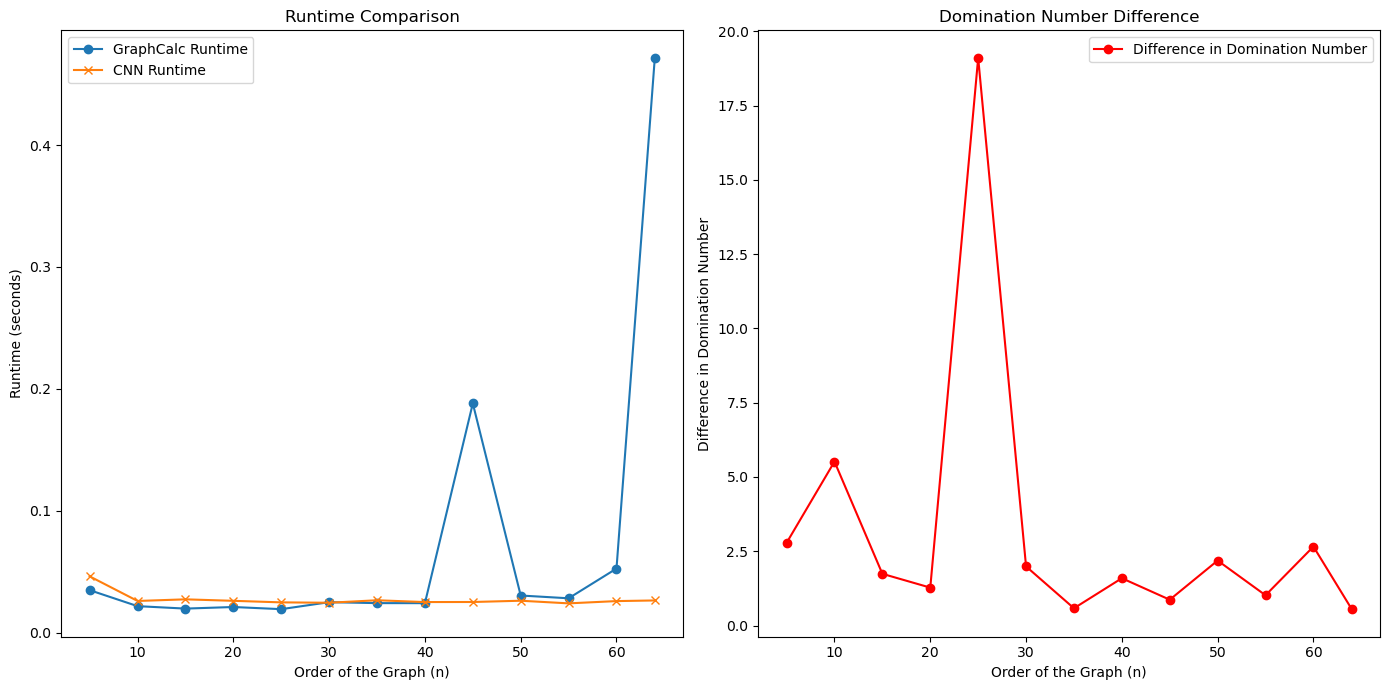

In [26]:
# Parameters
graph_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
graphcalc_times = []
cnn_times = []
domination_number_diffs = []

for n in graph_sizes:
    G = nx.gnp_random_graph(n, np.random.rand())

    # Measure time for GraphCalc method
    start_time = time.time()
    dom_num = gc.domination_number(G)
    graphcalc_time = time.time() - start_time

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    graphcalc_times.append(graphcalc_time)
    cnn_times.append(cnn_time)
    domination_number_diffs.append(abs(dom_num - cnn_pred))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot runtime comparison
ax1.plot(graph_sizes, graphcalc_times, label='GraphCalc Runtime', marker='o')
ax1.plot(graph_sizes, cnn_times, label='CNN Runtime', marker='x')
ax1.set_xlabel('Order of the Graph (n)')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime Comparison')
ax1.legend()

# Plot difference in domination numbers
ax2.plot(graph_sizes, domination_number_diffs, label='Difference in Domination Number', marker='o', color='r')
ax2.set_xlabel('Order of the Graph (n)')
ax2.set_ylabel('Difference in Domination Number')
ax2.set_title('Domination Number Difference')
ax2.legend()

plt.tight_layout()
plt.show()
